In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
import math
from sklearn.inspection import permutation_importance
#-----------------model-----------------------
from sklearn.svm import SVR
from sklearn import linear_model
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
#---------------------------------------------
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, max_error, r2_score

In [2]:
def rfecv(model, x_train, y_train):
  r = RFECV(estimator = model, step = 1, cv = 5, scoring = 'r2').fit(x_train, y_train)
  print("Optimal number of features : %d" % r.n_features_)
  print("Support : %s" % r.support_)
  print("Ranking : %s" % r.ranking_)

  return r.n_features_, r.support_

In [3]:
def fs_embedded(model, threshold, x_train, y_train):
  score = []
  best_threshold = 0
  best_score = 0
  for i in threshold:
    x_embedded = SelectFromModel(model, threshold = i).fit_transform(x_train, y_train)
    mean_score = cross_val_score(model, x_embedded, y_train, cv = 5, scoring = "r2").mean()
    score.append(mean_score)
    if(mean_score > best_score): 
      best_score = mean_score
      best_threshold = i
  
  print(best_threshold)
  print(best_score)
  plt.plot(threshold, score)
  plt.show()

  return best_threshold

In [4]:
def regression_model_evaluation_result(train_X,train_Y,test_X,test_Y,model):
    # Training and Prediction
    model.fit(train_X, train_Y)
    train_pred = model.predict(train_X)
    

    # Evaluation: Training
    size, var_num = train_X.shape
    train_R2 = r2_score(train_Y, train_pred)
    train_adj_R2 = 1-(1-train_R2)*(size-1)/(size-var_num-1)
    train_MAE = mean_absolute_error(train_Y, train_pred)
    train_MSE = mean_squared_error(train_Y, train_pred)
    train_RMSE = (train_MSE ** 0.5)
    train_Max_error = max_error(train_Y, train_pred)
    svr_train = pd.DataFrame(data = {"actual values":train_Y, "predicted values":train_pred})

    # Prediction: Test
    test_pred = model.predict(test_X)

    # Evaluation: Test
    test_R2 = r2_score(test_Y, test_pred)
    test_adj_R2 = 1-(1-test_R2)*(size-1)/(size-var_num-1)
    test_MAE = mean_absolute_error(test_Y, test_pred)
    test_MSE = mean_squared_error(test_Y, test_pred)
    test_RMSE = (test_MSE ** 0.5)
    test_Max_error = max_error(test_Y, test_pred)
    svr_test = pd.DataFrame(data = {"actual values":test_Y, "predicted values":test_pred})

    # Summary
    result = [{"Max error":train_Max_error, "MAE":train_MAE, "MSE":train_MSE, "RMSE":train_RMSE, "R2":train_R2, "Adjusted R2": train_adj_R2},
                {"Max error":test_Max_error, "MAE":test_MAE, "MSE":test_MSE, "RMSE":test_RMSE, "R2":test_R2, "Adjusted R2": test_adj_R2}]

    summary = pd.DataFrame(result)
    summary.index = ["Training", "Test"]
    summary.round(2)
    print(summary)

    return summary, svr_train, train_pred, svr_test, test_pred, model

In [5]:
def actual_vs_predict(tr_act, tr_pre, te_act, te_pre):
  #training
  plt.figure(figsize=(5, 5))
  plt.scatter(tr_act, tr_pre)
  plt.plot([tr_act, tr_pre],[tr_act, tr_pre], 'r-')
  plt.xlabel('actual Values ')
  plt.ylabel('Predictions value ')
  plt.axis('equal')
  plt.axis('square')
  plt.title('training')
  
  #test
  plt.figure(figsize=(5, 5))
  plt.scatter(te_act, te_pre)
  plt.plot([te_act, te_pre],[te_act, te_pre], 'r-')
  plt.xlabel('actual Values ')
  plt.ylabel('Predictions value ')
  plt.axis('equal')
  plt.axis('square')
  plt.title('test')

In [6]:
def Randomized_gridsearch(model, param_grid_, x_train, y_train_):
  optimal_params = RandomizedSearchCV(
      model,
      param_grid_,
      cv = 5,
      scoring = 'r2',
      verbose = 1,
      n_jobs = -1,
    )

  optimal_params.fit(x_train, y_train_)
  print(optimal_params.best_params_)
  return optimal_params.best_params_

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv('/content/drive/MyDrive/Regression_2weeks_data_v2.csv')

# **preprocessing**

In [9]:
train_df, test_df = train_test_split(df, test_size = 0.3, random_state = 0)

In [38]:
plt.figure(figsize=(8,60))
correlation_matrix = df.corr().loc[:,['label']]

ori_column = df.columns
column_and_corr = pd.DataFrame([ori_column, correlation_matrix['label']]).T
column_and_corr = column_and_corr.rename(columns = {0:'features', 1:'pearson'})
print(column_and_corr)

    features   pearson
0         d1  0.005184
1         d2 -0.011968
2         d3  0.007046
3         d4 -0.032338
4         d5 -0.005653
..       ...       ...
512     c513  0.001803
513     c514  0.014264
514     c515 -0.001792
515     c516  -0.00125
516    label       1.0

[517 rows x 2 columns]


<Figure size 800x6000 with 0 Axes>

In [40]:
prefeature = []

for i in column_and_corr.iloc:
  if(abs(i['pearson']) >= 0.03 and abs(i['pearson']) != 1): prefeature.append(i['features'])

print(prefeature)
print(len(prefeature))

train_predata = train_df.loc[:, prefeature]
test_predata = test_df.loc[:, prefeature]

# print(train_predata)
# print(test_predata)

['d4', 'd6', 'd18', 'd20', 'd26', 'd28', 'd35', 'd36', 'd37', 'd38', 'c42', 'c45', 'c59', 'c64', 'c70', 'c73', 'c76', 'c82', 'c83', 'c89', 'c93', 'c96', 'c110', 'c112', 'c115', 'c124', 'c127', 'c133', 'c140', 'c147', 'c161', 'c163', 'c166', 'c175', 'c178', 'c184', 'c187', 'c191', 'c194', 'c195', 'c205', 'c210', 'c212', 'c214', 'c217', 'c220', 'c223', 'c225', 'c226', 'c229', 'c231', 'c236', 'c239', 'c240', 'c246', 'c249', 'c256', 'c261', 'c263', 'c265', 'c271', 'c274', 'c276', 'c277', 'c280', 'c282', 'c283', 'c287', 'c289', 'c290', 'c291', 'c307', 'c312', 'c328', 'c358', 'c363', 'c373', 'c379', 'c393', 'c409', 'c414', 'c416', 'c430', 'c435', 'c444', 'd500', 'c501', 'c502', 'c503', 'c504', 'c506', 'c508']
92


In [41]:
y_train = train_df.iloc[:, -1]
y_test = test_df.iloc[:, -1]

scaler_std = preprocessing.StandardScaler().fit(train_predata)
x_pretrain_std = scaler_std.transform(train_predata)
x_pretest_std = scaler_std.transform(test_predata)

x_pretrain_std = pd.DataFrame(x_pretrain_std)
x_pretest_std = pd.DataFrame(x_pretest_std)
x_pretrain_std.columns = prefeature
x_pretest_std.columns = prefeature

# **static only**

**SVR**

In [42]:
param_grid = {
        'kernel': ["rbf"],
        'C': [256, 128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125],
        'gamma': [256, 128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125]
        }

model = SVR()
best_para = Randomized_gridsearch(model, param_grid, x_pretrain_std, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'kernel': 'rbf', 'gamma': 0.0625, 'C': 64}


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training   0.100507  0.091535  0.008885  0.094263  0.995419     0.995340
Test      12.384216  0.514674  0.938819  0.968927  0.230002     0.216815


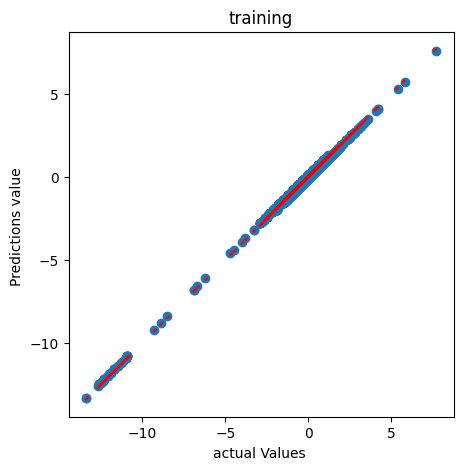

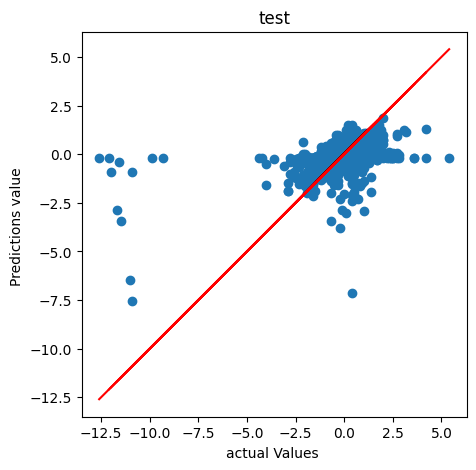

In [44]:
svr_model=SVR(**best_para)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(x_pretrain_std, y_train, x_pretest_std, y_test, svr_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

**ElasticNet**

In [ ]:
l1_ratio = np.linspace(0.001, 1, 50)
best_score = 0
op_al = 0
op_l1 = 0

for j in l1_ratio:
  elastic_cv = linear_model.ElasticNetCV(cv= 5, random_state = 0, l1_ratio = j)
  elastic_cv.fit(x_pretrain_std, y_train)
  score = elastic_cv.score(x_pretrain_std, y_train)

  if(score > best_score):
    op_al = elastic_cv.alpha_
    op_l1 = j
    best_score = score

# print(elastic_cv.alpha_)
# print(elastic_cv.l1_ratio_)
print(op_al)
print(op_l1)

串流輸出內容已截斷至最後 5000 行。
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.97481128811614, tolerance: 0.8168945544030182
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.80681260810707, tolerance: 0.8168945544030182
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8771157347409826, tolerance: 0.8412366573072956
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_desce

0.01637868079714925
1.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.883120265832076, tolerance: 0.8679085778682518
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.73908175651195, tolerance: 0.8679085778682518
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.67046126940568, tolerance: 0.8679085778682518
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Convergenc

          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training  12.465616  0.638956  1.715917  1.309930  0.115255     0.100103
Test      12.047188  0.596509  1.081804  1.040098  0.112729     0.097534


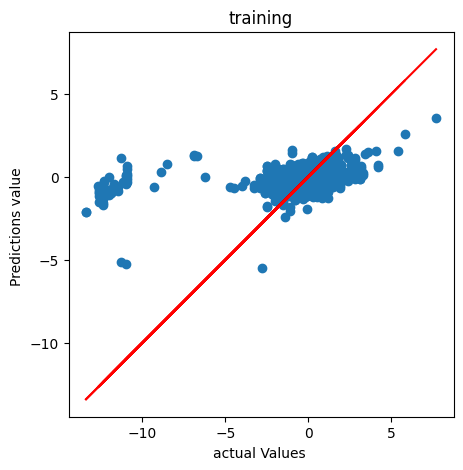

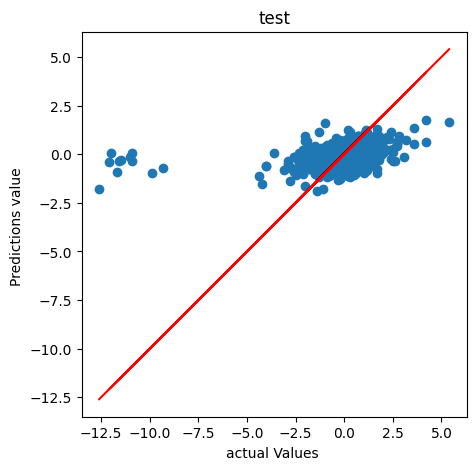

In [ ]:
elastic_model = linear_model.ElasticNet(alpha = op_al ,l1_ratio = op_l1)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(x_pretrain_std, y_train, x_pretest_std, y_test, elastic_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

**XGBR**

In [ ]:
param = {
    'eta':np.linspace(0.01, 0.2, 10),
    'gamma':np.linspace(0.001, 30, 40),
    'max_depth':range(3, 11)
}

model = XGBRegressor(objective='reg:squarederror')
best_para = Randomized_gridsearch(model, param, x_pretrain_std, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'max_depth': 10, 'gamma': 6.923846153846154, 'eta': 0.052222222222222225}


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training   5.287173  0.402533  0.313040  0.559500  0.838593     0.835829
Test      11.739712  0.498022  0.671104  0.819209  0.449576     0.440149


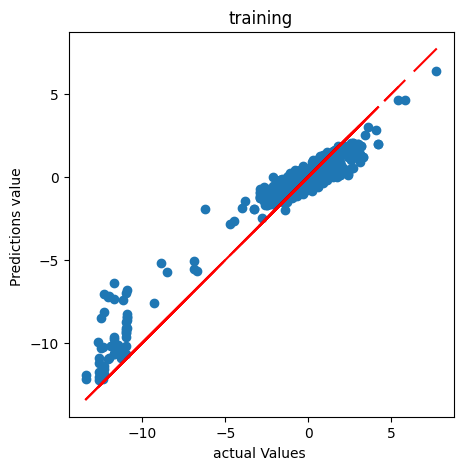

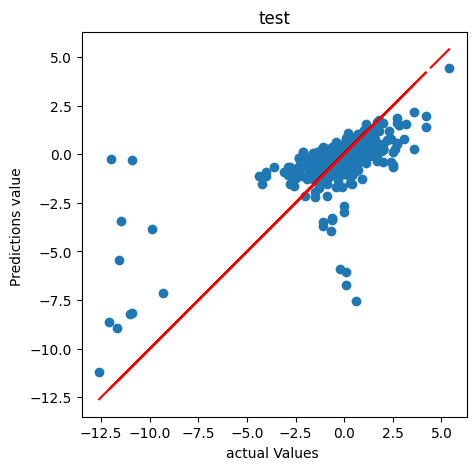

In [ ]:
xgbr_model=XGBRegressor(**best_para)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(x_pretrain_std, y_train, x_pretest_std, y_test, xgbr_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

**GBR**

In [ ]:
param = {
    'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
    'learning_rate':np.linspace(0.01, 2, 10),
    'n_estimators': range(1, 100, 10)
}

model = GradientBoostingRegressor()
best_para = Randomized_gridsearch(model, param, x_pretrain_std, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 71, 'loss': 'huber', 'learning_rate': 0.6733333333333333}


          Max error       MAE       MSE     RMSE        R2  Adjusted R2
Training  12.314288  0.385380  0.906666  0.95219  0.532513     0.524507
Test      12.003048  0.484862  0.883920  0.94017  0.275029     0.262613


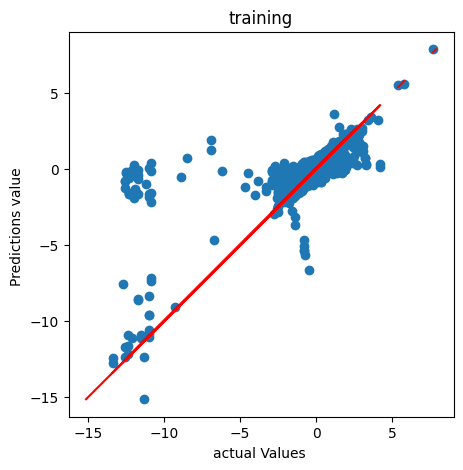

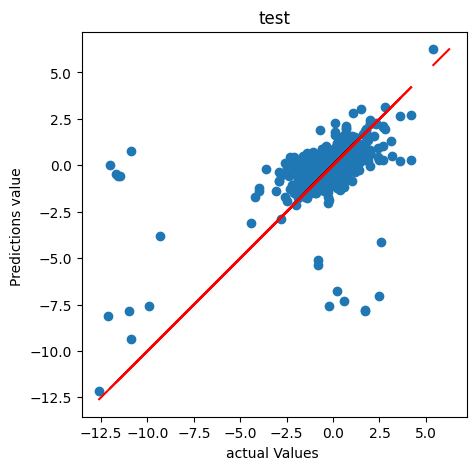

In [ ]:
gbr_model = GradientBoostingRegressor(**best_para)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(x_pretrain_std, y_train, x_pretest_std, y_test, gbr_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

# **feature selection**

**SVR**

In [ ]:
permut_model = SVR(kernel = "rbf").fit(x_pretrain_std, y_train)

perm = permutation_importance(permut_model, x_pretrain_std, y_train, n_repeats = 5, scoring = "r2", random_state=0)

In [ ]:
important_features=[]
for i in perm.importances_mean.argsort()[::-1]:
  if perm.importances_mean[i] > perm.importances_mean.mean() * 0.75:
    important_features.append(x_pretrain_std.columns[i])

print("n_feature: ", len(important_features))
print(important_features)

n_feature:  61
['c277', 'c73', 'c194', 'c124', 'c280', 'c265', 'c290', 'c226', 'c83', 'c70', 'c191', 'c263', 'c212', 'c291', 'c289', 'c127', 'c76', 'c140', 'c178', 'c93', 'c261', 'd6', 'c89', 'c175', 'c430', 'c210', 'c379', 'c184', 'c82', 'c205', 'c240', 'c133', 'c256', 'c502', 'c96', 'c187', 'c276', 'c220', 'c42', 'c115', 'd35', 'd28', 'c64', 'c271', 'd36', 'c307', 'c416', 'c358', 'd20', 'c283', 'c147', 'c409', 'c59', 'c504', 'c287', 'd4', 'c328', 'c45', 'c166', 'c282', 'c161']


In [ ]:
svr_train = x_pretrain_std.loc[:, important_features]
svr_test = x_pretest_std.loc[:, important_features]

In [ ]:
param_grid = {
        'kernel': ["rbf"],
        'C': [256, 128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125],
        'gamma': [256, 128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125]
        }

model = SVR()
best_para = Randomized_gridsearch(model, param_grid, svr_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'kernel': 'rbf', 'gamma': 0.03125, 'C': 128}


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training  11.069954  0.099536  0.060557  0.246082  0.968776     0.968424
Test      11.759248  0.427039  0.626034  0.791223  0.486541     0.480745


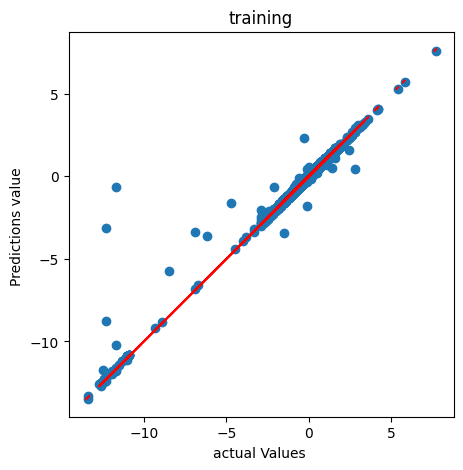

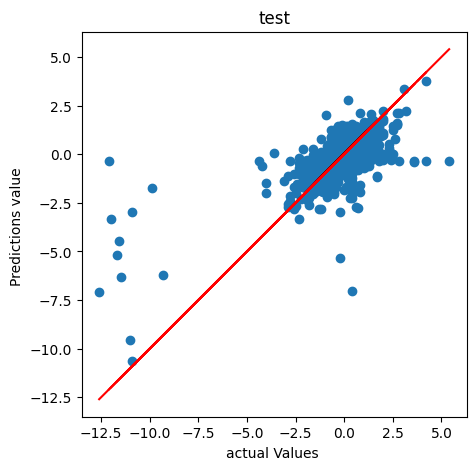

In [ ]:
svr_model=SVR(**best_para)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(svr_train, y_train, svr_test, y_test, svr_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

**Elastic**

//RFECV

In [ ]:
elastic_cv = linear_model.ElasticNetCV(cv= 5, random_state = 0, l1_ratio = 0.1)
elastic_cv.fit(x_pretrain_std, y_train)

print(elastic_cv.alpha_)

0.15274812528953316


In [ ]:
en = elastic_model = linear_model.ElasticNet(alpha=0.15274812528953316,l1_ratio=0.1)
n_feature, selected = rfecv(en, x_pretrain_std, y_train)

Optimal number of features : 45
Support : [False  True  True  True False  True  True False False False  True  True
 False False  True  True  True False  True  True  True  True False False
  True  True  True  True  True False False  True False False False False
  True  True  True False  True  True False False False  True False False
 False False False False False  True  True  True  True False  True  True
 False False  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False  True
 False  True False  True  True False False  True]
Ranking : [48  1  1  1  8  1  1 13 11 21  1  1 27  5  1  1  1  6  1  1  1  1  9  7
  1  1  1  1  1 32 33  1 38 40 42  4  1  1  1 29  1  1 34 10 44  1 47 18
  3 35 36 25 26  1  1  1  1 15  1  1 16 12  1  1  1  1  1  1  1  1 37 39
 41 43 45 46 24  2 22 31 20 19 30  1 28  1 23  1  1 14 17  1]


In [ ]:
en_train_data = train_predata.loc[:, selected]
en_test_data = test_predata.loc[:, selected]

In [ ]:
en_scaler_std = preprocessing.StandardScaler().fit(en_train_data)
en_x_train_std = en_scaler_std.transform(en_train_data)
en_x_test_std = en_scaler_std.transform(en_test_data)

In [ ]:
elastic_cv = linear_model.ElasticNetCV(alphas = np.linspace(0.001, 1, 200), cv= 5, random_state = 0, l1_ratio = np.linspace(0.001, 1, 100))
elastic_cv.fit(en_x_train_std, y_train)

print(elastic_cv.alpha_)
print(elastic_cv.l1_ratio_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3471.9546339483218, tolerance: 0.8168945544030182
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3492.811689005421, tolerance: 0.8412366573072956
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3439.448357120303, tolerance: 0.8153541419144561
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Convergenc

0.1817236180904523
0.001


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266.5219254791391, tolerance: 0.8980557622478268
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283.78904289343336, tolerance: 0.8679085778682518
  model = cd_fast.enet_coordinate_descent_gram(


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training  12.461932  0.646600  1.714584  1.309421  0.115942     0.108600
Test      12.052008  0.603042  1.083056  1.040700  0.111702     0.104326


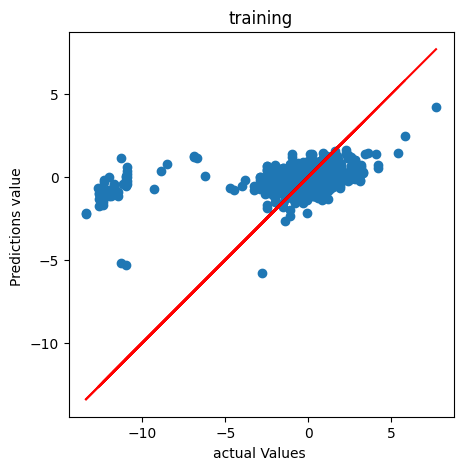

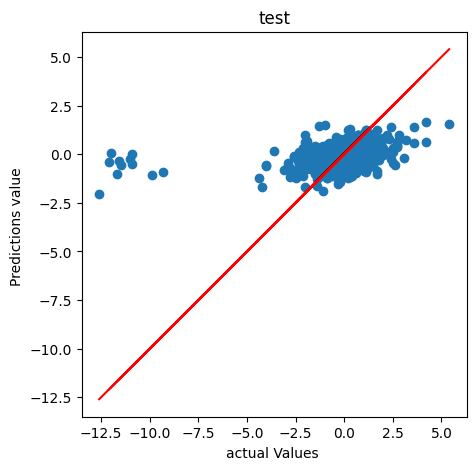

In [ ]:
elastic_model = linear_model.ElasticNet(alpha=0.1817236180904523,l1_ratio=0.001)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(en_x_train_std, y_train, en_x_test_std, y_test, elastic_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

//embedded

In [ ]:
elastic_cv = linear_model.ElasticNetCV(cv= 5, random_state = 0)
elastic_cv.fit(x_pretrain_std, y_train)

print(elastic_cv.alpha_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4408366073475918, tolerance: 0.8168945544030182
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7161606425734135, tolerance: 0.8168945544030182
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.716688167182838, tolerance: 0.8168945544030182
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Convergen

0.032757361594298505


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.35742780565124, tolerance: 0.8679085778682518
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.321699836646076, tolerance: 0.8679085778682518
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.59407118965828, tolerance: 0.8679085778682518
  model = cd_fast.enet_coordinate_descent_gram(


In [ ]:
elastic_model = linear_model.ElasticNet(alpha=0.032757361594298505)
elastic_model.fit(x_pretrain_std, y_train)

threshold = []
for i in elastic_model.coef_:
  if(i != 0): threshold.append(i)

preselected = np.array(elastic_model.coef_[:] != 0)
en_train_predata = train_predata.loc[:, preselected]
en_test_predata = test_predata.loc[:, preselected]
threshold.sort()

In [ ]:
en_scaler_std = preprocessing.StandardScaler().fit(en_train_predata)
en_x_pretrain_std = en_scaler_std.transform(en_train_predata)
en_x_pretest_std = en_scaler_std.transform(en_test_predata)

0.02804560665335097
0.0898475240533797


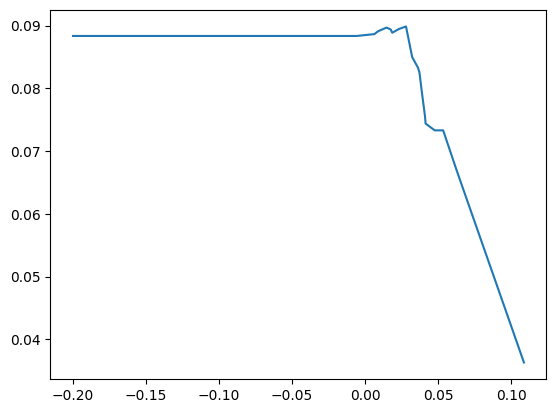

In [ ]:
best_threshold = fs_embedded(elastic_model, threshold, en_x_pretrain_std, y_train)

In [ ]:
selected = np.array(elastic_model.coef_[:] >= best_threshold)

# print(preselected)
# print(selected)

en_train_data = train_predata.loc[:, selected]
en_test_data = test_predata.loc[:, selected]

en_scaler_std = preprocessing.StandardScaler().fit(en_train_data)
en_x_train_std = en_scaler_std.transform(en_train_data)
en_x_test_std = en_scaler_std.transform(en_test_data)

In [ ]:
l1_ratio = np.linspace(0.001, 1, 200)
best_score = 0
op_al = 0
op_l1 = 0

for j in l1_ratio:
  elastic_cv = linear_model.ElasticNetCV(cv= 5, random_state = 0, l1_ratio = j)
  elastic_cv.fit(en_x_train_std, y_train)

  if(elastic_cv.score(en_x_train_std, y_train) > best_score):
    op_al = elastic_cv.alpha_
    op_l1 = j
    best_score = elastic_cv.score(en_x_train_std, y_train)

# print(elastic_cv.alpha_)
# print(elastic_cv.l1_ratio_)
print(op_al)
print(op_l1)

0.00886440135161332
1.0


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training  13.412039  0.680154  1.879298  1.370875  0.031013     0.028881
Test      12.406036  0.636402  1.205265  1.097846  0.011469     0.009293


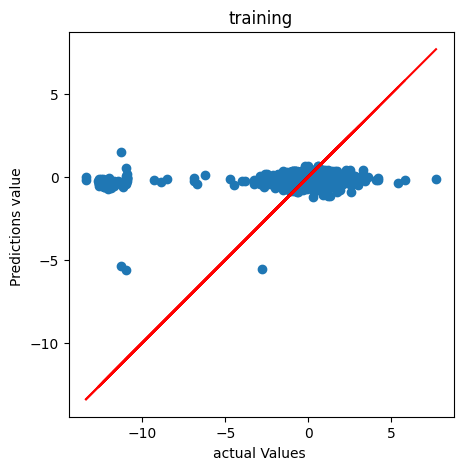

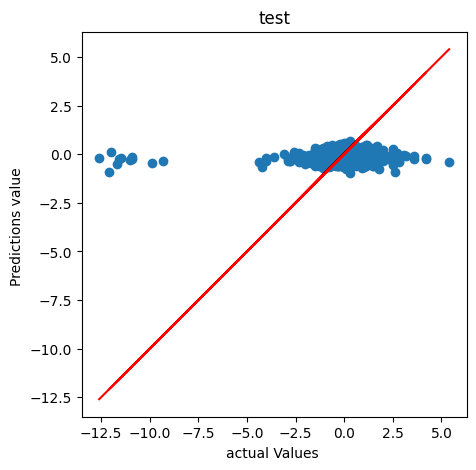

In [ ]:
elastic_model = linear_model.ElasticNet(alpha=op_al,l1_ratio=op_l1)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(en_x_train_std, y_train, en_x_test_std, y_test, elastic_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

//origin

In [ ]:
X_train = train_df.iloc[:,0:-1]
X_test = test_df.iloc[:,0:-1]

scaler_Std = preprocessing.StandardScaler().fit(X_train)
X_train_Std = scaler_Std.transform(X_train)
X_test_Std = scaler_Std.transform(X_test)

In [ ]:
elastic_cv = linear_model.ElasticNetCV(cv= 5, random_state = 0)
elastic_cv.fit(X_train_Std, y_train)

print(elastic_cv.alpha_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8763056429415883, tolerance: 0.8168945544030182
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9512875493419415, tolerance: 0.8168945544030182
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0290821420067005, tolerance: 0.8168945544030182
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Converge

0.037663005643817846


In [ ]:
elastic_model = linear_model.ElasticNet(alpha = 0.037663005643817846)
elastic_model.fit(X_train_Std, y_train)

threshold = []
for i in elastic_model.coef_:
  if(i != 0): threshold.append(i)

preselected = np.array(elastic_model.coef_[:] != 0)
en_train_predata = X_train.loc[:, preselected]
en_test_predata = X_test.loc[:, preselected]
threshold.sort()

In [ ]:
en_scaler_std = preprocessing.StandardScaler().fit(en_train_predata)
en_x_pretrain_std = en_scaler_std.transform(en_train_predata)
en_x_pretest_std = en_scaler_std.transform(en_test_predata)

0.01876718925875847
0.10008039816438385


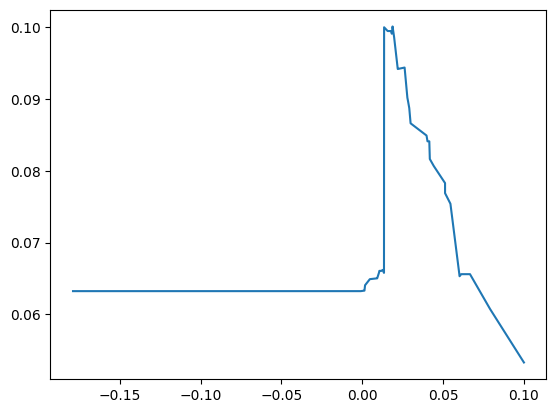

In [ ]:
best_threshold = fs_embedded(elastic_model, threshold, en_x_pretrain_std, y_train)

In [ ]:
selected = np.array(elastic_model.coef_[:] >= best_threshold)
en_train_data = X_train.loc[:, selected]
en_test_data = X_test.loc[:, selected]

en_scaler_std = preprocessing.StandardScaler().fit(en_train_data)
en_x_train_std = en_scaler_std.transform(en_train_data)
en_x_test_std = en_scaler_std.transform(en_test_data)

In [ ]:
l1_ratio = np.linspace(0.0001, 1, 200)
best_score = 0
alpha = 0
best_l1_ratio = 0

for i in l1_ratio:
  elastic_cv = linear_model.ElasticNetCV(cv= 5, random_state = 0, l1_ratio = i)
  elastic_cv.fit(en_x_train_std, y_train)
  score = elastic_cv.score(en_x_train_std, y_train)

  if(score > best_score):
    alpha = elastic_cv.alpha_
    best_l1_ratio = i
    best_score = score

print(alpha)
print(best_l1_ratio)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8705892541238427, tolerance: 0.8679085778682518
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8750396354244003, tolerance: 0.8679085778682518
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8792836128704948, tolerance: 0.8679085778682518
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Converge

0.003337390205446853
1.0


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training  13.150894  0.683562  1.862345  1.364678  0.039754     0.035872
Test      12.102527  0.646143  1.215415  1.102459  0.003144    -0.000886


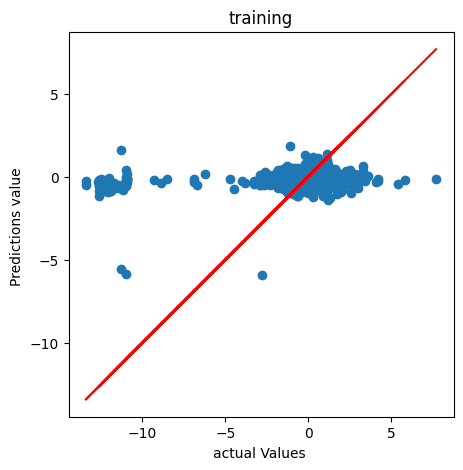

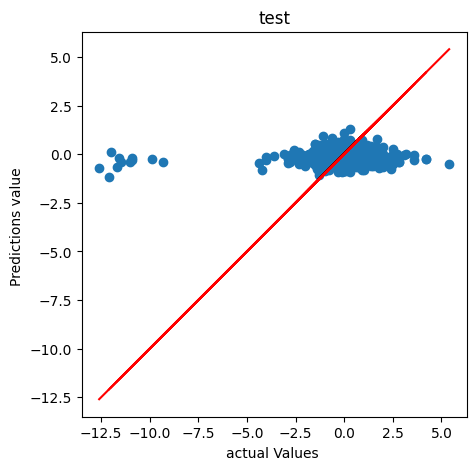

In [ ]:
elastic_model = linear_model.ElasticNet(alpha=alpha,l1_ratio=best_l1_ratio)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(en_x_train_std, y_train, en_x_test_std, y_test, elastic_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

**XGBR**

In [ ]:
xgbr = XGBRegressor(objective='reg:squarederror')
n_feature, selected = rfecv(xgbr, x_pretrain_std, y_train)

Optimal number of features : 14
Support : [ True False False False False False  True False False False False False
  True False False  True False False False False False False  True  True
  True False False  True False False False  True False False False  True
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False  True False False  True
 False False False False False False False False False False False False
 False False False False False False False False]
Ranking : [ 1  9 78 42 17 12  1 63 38 65 28 40  1 11 16  1  8  5  4 35  2 23  1  1
  1 52 19  1 77 25 47  1 24 31 26  1  7 69 13 32  1 62 59 27 50 30 66 67
 36 20 64 48 76 70 44 51 79 18 22 21 29 54 15  3  1 10 43 34  1 14  6  1
 61 41 73 55 49 56 45 75 68 33 57 71 74 72 37 53 39 58 60 46]


In [ ]:
xgbr_train_data = train_predata.loc[:, selected]
xgbr_test_data = test_predata.loc[:, selected]

In [ ]:
xgbr_scaler_std = preprocessing.StandardScaler().fit(xgbr_train_data)
xgbr_train_std = xgbr_scaler_std.transform(xgbr_train_data)
xgbr_test_std = xgbr_scaler_std.transform(xgbr_test_data)

In [ ]:
param = {
    'eta':np.linspace(0.01, 0.2, 10),
    'gamma':np.linspace(0.001, 30, 40),
    'max_depth':range(3, 11)
}

xgbr = XGBRegressor(objective='reg:squarederror')
best_para = Randomized_gridsearch(xgbr, param, xgbr_train_std, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'max_depth': 9, 'gamma': 0.001, 'eta': 0.1366666666666667}


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training   3.419318  0.163887  0.057592  0.239984  0.970305     0.970228
Test      11.846824  0.353341  0.590619  0.768517  0.515588     0.514343


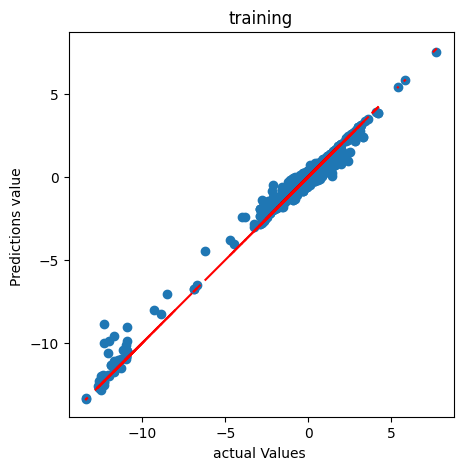

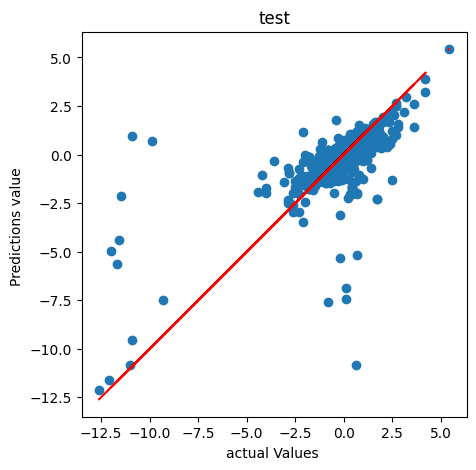

In [ ]:
xgbr_model=XGBRegressor(**best_para)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(xgbr_train_std, y_train, xgbr_test_std, y_test, xgbr_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

**GBR**

In [ ]:
gbr = GradientBoostingRegressor()
n_feature, selected = rfecv(gbr, x_pretrain_std, y_train)

Optimal number of features : 37
Support : [False False False False False False False False False False False False
  True  True False  True  True False  True False  True False  True  True
  True  True False  True False False False  True  True  True False  True
  True False  True  True  True False False False False False False False
 False False False False False False  True False  True  True  True  True
  True False  True  True  True  True False  True  True  True  True  True
 False  True  True False False  True False False False False False False
 False False False False False False False False]
Ranking : [56 26 44 43 10  6 33 42 40 48 23 20  1  1 19  1  1 18  1 45  1 11  1  1
  1  1 15  1 50 17  2  1  1  1 25  1  1  4  1  1  1 27 37 49 51  3 55 28
  5 36 46 12 38 13  1 14  1  1  1  1  1  7  1  1  1  1 24  1  1  1  1  1
 39  1  1 21 30  1 53 34 52 29  8 54 47 41  9 16 32 31 35 22]


In [ ]:
gbr_train_data = train_predata.loc[:, selected]
gbr_test_data = test_predata.loc[:, selected]

In [ ]:
gbr_scaler_std = preprocessing.StandardScaler().fit(gbr_train_data)
gbr_train_std = gbr_scaler_std.transform(gbr_train_data)
gbr_test_std = gbr_scaler_std.transform(gbr_test_data)

In [ ]:
param = {
    'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
    'learning_rate':np.linspace(0.01, 2, 10),
    'n_estimators': range(1, 100, 10)
}

gbr = GradientBoostingRegressor()
best_para = Randomized_gridsearch(gbr, param, gbr_train_std, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'n_estimators': 41, 'loss': 'squared_error', 'learning_rate': 0.45222222222222225}


          Max error       MAE       MSE      RMSE        R2  Adjusted R2
Training  11.941781  0.474332  0.555250  0.745151  0.713707     0.711755
Test      11.724342  0.535945  0.855899  0.925148  0.298011     0.293225


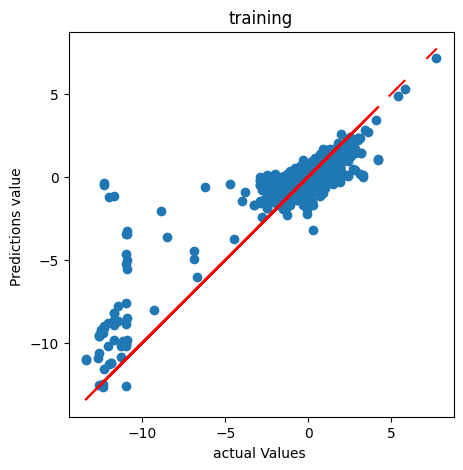

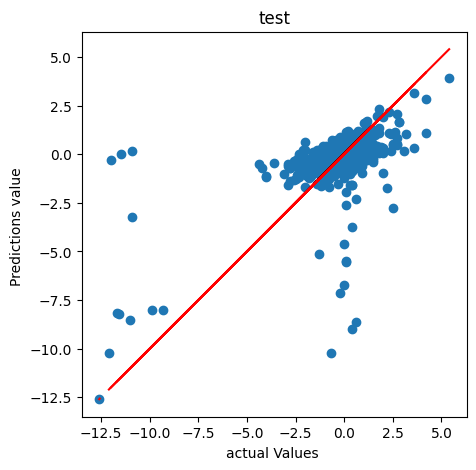

In [ ]:
gbr_model=GradientBoostingRegressor(**best_para)
df_svr, tr_predsc, tr_predlabel, te_predsc, te_predlabel, model = regression_model_evaluation_result(gbr_train_std, y_train, gbr_test_std, y_test, gbr_model)
actual_vs_predict(y_train, tr_predlabel, y_test, te_predlabel)

# load

In [ ]:
from joblib import dump, load

In [ ]:
dump(xgbr_model, "regression.joblib")

['regression.joblib']

In [ ]:
f = xgbr_train_data.columns.to_list()

In [ ]:
f = pd.DataFrame(f).T

In [ ]:
f

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,d4,d35,c59,c73,c110,c112,c115,c133,c163,c184,c205,c280,c289,c307


In [ ]:
f.to_csv("/content/drive/MyDrive/feature_regression.csv", index = False)